## Học phần: Thị giác máy tính
#### Nhóm 9:
- Phạm Phước Bảo Tín - 22E1020021
- Lê Quý Minh Quang - 22E1020007
- Trịnh Quốc Dân - 22E1020014 

## Mô tả dữ liệu
- Bộ dữ liệu về phân loại "Shoe", "Sandal", "Boot". Nguồn dữ liệu : Kaggle ([Shoe vs Sandal vs Boot Image Dataset](https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images?fbclid=IwZXh0bgNhZW0CMTEAAR4Qhm5prfJKpfYH3kwbWi-Tcsk1Q1AHnBqh4scpOWhT4CTERDLwisuTuvNcDg_aem_8fGVUmMtZuHu_Cmj3jxaCg)).
- Ba lớp 3 thư mục riêng, mỗi thư mục 5000 ảnh.


## Chuẩn bị dữ liệu

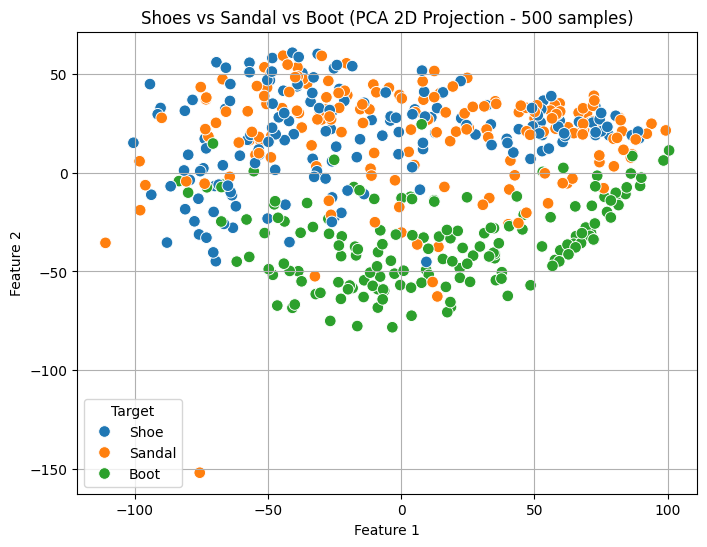

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import pandas as pd
# ======================
# 1. Chuẩn bị dữ liệu
# ======================
data_dir = r"D:\datasets\ShoeSandalBoot"
classes = ["Shoe", "Sandal", "Boot"]
  # resize ảnh kích thước 120x120

X = []
y = []

img_size = (120, 120)

for label, c in enumerate(classes):
    folder = os.path.join(data_dir, c)
    for img_file in os.listdir(folder)[:15000]:  
        img = load_img(os.path.join(folder, img_file), target_size=img_size, color_mode="grayscale")
        arr = img_to_array(img).flatten() / 255.0  # 120*120 = 14400 features
        X.append(arr)
        y.append(c)

X = np.array(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

df = pd.DataFrame(X_2d, columns=["Feature 1", "Feature 2"])
df["Target"] = y

sample_idx = np.random.choice(len(df), size=500, replace=False)
df_sample = df.iloc[sample_idx]

# Vẽ PCA 2D chỉ với 500 điểm
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_sample,
    x="Feature 1", y="Feature 2",
    hue="Target", palette="tab10", legend="full", s=70
)
plt.title("Shoes vs Sandal vs Boot (PCA 2D Projection - 500 samples)")
plt.grid(True)
plt.show()

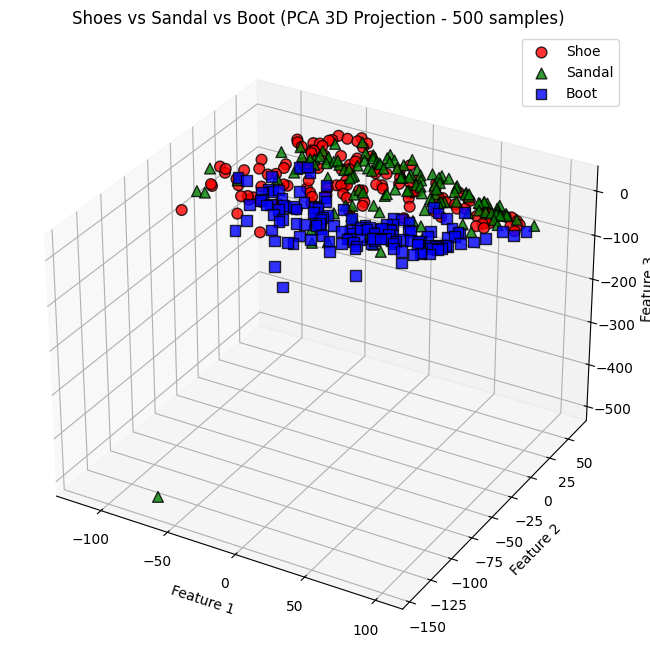

In [2]:
#PCA 3 chiều
pca = PCA(n_components=3)
X_3d = pca.fit_transform(X_scaled)

df = pd.DataFrame(X_3d, columns=["Feature 1", "Feature 2", "Feature 3"])
df["Target"] = y

# Lấy ngẫu nhiên 500 điểm để vẽ
sample_idx = np.random.choice(len(df), size=400, replace=False)
df_sample = df.iloc[sample_idx]

# Vẽ scatter 3D
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
markers = ['o', '^', 's', 'D', 'P', 'X', '*']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i, target in enumerate(df_sample["Target"].unique()):
    subset = df_sample[df_sample["Target"] == target]
    ax.scatter(
        subset["Feature 1"],
        subset["Feature 2"],
        subset["Feature 3"],
        c=colors[i % len(colors)],
        marker=markers[i % len(markers)],
        label=target,
        alpha=0.8,
        s=60,
        edgecolors='k'
    )

ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
ax.set_title("Shoes vs Sandal vs Boot (PCA 3D Projection - 500 samples)")
ax.legend()
plt.show()

## Chia tập dữ liệu

In [4]:

# ======================
# 2. Chia dữ liệu
# ======================
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=40, stratify=y
)
print("Train:", len(X_train), "| Test:", len(X_test))

Train: 12000 | Test: 3000


So Sánh accuracy theo k, số lẻ

k=1, Accuracy=0.8923
k=3, Accuracy=0.8830
k=5, Accuracy=0.8813
k=7, Accuracy=0.8790
k=9, Accuracy=0.8743
k=11, Accuracy=0.8700


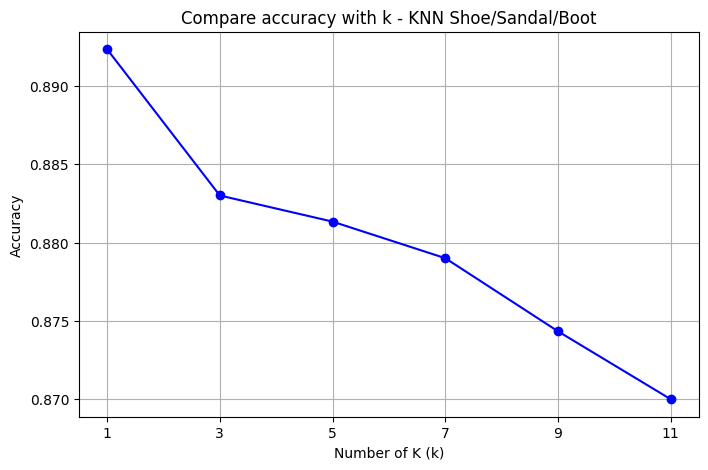

In [5]:
# 3. So sánh accuracy theo k
# ======================
k_values = range(1, 12, 2)
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric="euclidean")
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"k={k}, Accuracy={acc:.4f}")

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker="o", linestyle="-", color="b")
plt.xticks(k_values)
plt.xlabel("Number of K (k)")
plt.ylabel("Accuracy")
plt.title("Compare accuracy with k - KNN Shoe/Sandal/Boot")
plt.grid(True)
plt.show()


Chọn k (từ kết quả thử nghiệm trên)

In [6]:
# ======================
# 3. Huấn luyện KNN
# ======================
k=5
knn_k = KNeighborsClassifier(n_neighbors=k, metric="euclidean")
knn_k.fit(X_train, y_train)

# ======================
# 4. Đánh giá mô hình
# ======================
y_pred = knn_k.predict(X_test)

# Độ chính xác trên tập train
y_train_pred = knn_k.predict(X_train)

print("🔹 Train Accuracy:", accuracy_score(y_train, y_train_pred))

print("🔹 Test Accuracy:", accuracy_score(y_test, y_pred))

print("\n🔹 Classification Report Test:\n", classification_report(y_test, y_pred, target_names=classes))



🔹 Train Accuracy: 0.9118333333333334
🔹 Test Accuracy: 0.8813333333333333

🔹 Classification Report Test:
               precision    recall  f1-score   support

        Shoe       0.84      0.98      0.90      1000
      Sandal       0.94      0.75      0.83      1000
        Boot       0.88      0.91      0.90      1000

    accuracy                           0.88      3000
   macro avg       0.89      0.88      0.88      3000
weighted avg       0.89      0.88      0.88      3000



Vẽ ma trận nhầm lẫn trên tập test với K đã chọn

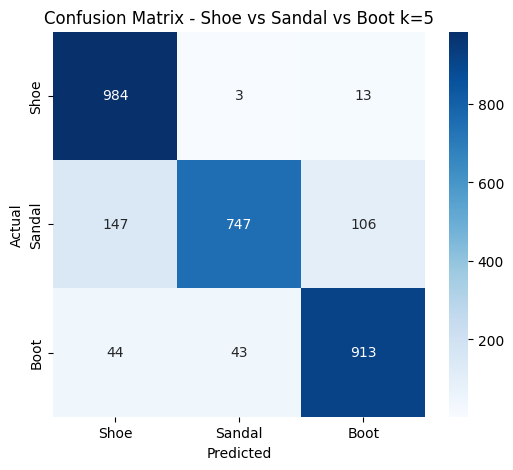

In [7]:
# 5. Ma trận nhầm lẫn
# ======================
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - Shoe vs Sandal vs Boot k={k}")
plt.show()


## Phân loại ảnh thực tế

In [ ]:
# ======================
# 6. Hàm dự đoán ảnh trong folder
# ======================
def predict_folder(folder_path, limit=None):
    results = []
    count = 0
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img_original=cv2.imread(img_path)  # đọc ảnh màu
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # đọc ảnh Gray
        if img is None:
            continue

        img_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB) 

        img = cv2.resize(img, img_size)                   # (120,120)
        img_flat = img.flatten().reshape(1, -1) / 255.0
        img_scaled = scaler.transform(img_flat)
        prediction = knn_k.predict(img_scaled)[0]

        # Xác suất theo phiếu bầu
        proba = knn_k.predict_proba(img_scaled)[0]
        class_names = knn_k.classes_
        proba_text = ", ".join([f"{cls}:{p:.2f}" for cls, p in zip(class_names, proba)])

        results.append((filename, prediction, proba_text))

        

        plt.imshow(img_rgb, cmap="gray")
        plt.title(f"{filename}\nDự đoán: {prediction}\n  {proba_text}")
        plt.axis("off")
        plt.show()

        print(f"{filename} → {prediction}")

        count += 1
        if limit and count >= limit:
            break
    
    return results
test_dir = r"D:\datasets\test"
results = predict_folder(test_dir, limit=50) 


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:\\test'

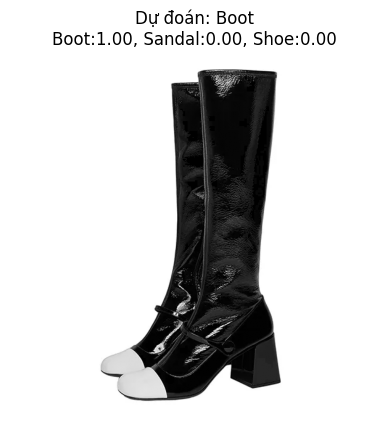

D:\datasets\t1.png → Boot (Boot:1.00, Sandal:0.00, Shoe:0.00)


np.str_('Boot')

In [ ]:
from fileinput import filename
def predict_image(img_path):
    img_original = cv2.imread(img_path)  # ảnh màu
    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    if img_original is None or img_gray is None:
        print(f"Không đọc được ảnh: {img_path}")
        return None
    
    # Resize + flatten
    img_resized = cv2.resize(img_gray, img_size)   # (120,120)
    img_flat = img_resized.flatten().reshape(1, -1) / 255.0

    # Scale (giống train)
    img_scaled = scaler.transform(img_flat)

    # Dự đoán
    prediction = knn_k.predict(img_scaled)[0]
    proba = knn_k.predict_proba(img_scaled)[0]  # xác suất
    class_names = knn_k.classes_
    proba_text = ", ".join([f"{cls}:{p:.2f}" for cls, p in zip(class_names, proba)])

    # Hiển thị ảnh gốc
    img_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    plt.imshow(img_gray, cmap="gray")
    plt.title(f"Dự đoán: {prediction}\n{proba_text}")
    plt.axis("off")
    plt.show()

    print(f"{img_path} → {prediction} ({proba_text})")
    return prediction

predict_image(r"D:\datasets\t1.png")
